# Cost Savings Analysis with Prophet Model

This notebook demonstrates how to analyze cost savings by optimizing consumption based on price predictions from a Prophet model.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import logging
import os
from datetime import datetime, timedelta

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Cost Savings Analyzer Class

This class handles the optimization of consumption based on price predictions and calculates the resulting cost savings.

In [18]:
class CostSavingsAnalyzer:
    def __init__(self, avg_daily_consumption: float = 1000.0):
        """Initialize the analyzer with average daily consumption"""
        self.avg_daily_consumption = avg_daily_consumption
        self.logger = logging.getLogger(__name__)
    
    def optimize_consumption(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optimize consumption based on predicted prices"""
        self.logger.info("Starting consumption optimization...")
        
        # Create a copy of the dataframe
        df = df.copy()
        
        # Use actual prices when predicted prices are NaN
        df['price_for_optimization'] = df['predicted_price'].fillna(df['actual_price'])
        
        # Calculate price percentiles
        price_percentiles = df['price_for_optimization'].quantile([0.33, 0.66])
        low_price_threshold = price_percentiles[0.33]
        high_price_threshold = price_percentiles[0.66]
        
        # Initialize optimized consumption
        df['optimized_consumption'] = self.avg_daily_consumption
        
        # Count days in each price category
        low_price_days = (df['price_for_optimization'] <= low_price_threshold).sum()
        high_price_days = (df['price_for_optimization'] >= high_price_threshold).sum()
        medium_price_days = len(df) - low_price_days - high_price_days
        
        # Calculate consumption adjustments
        if low_price_days > 0:
            # On low price days, consume 20% more than average
            low_price_consumption = self.avg_daily_consumption * 1.2
            df.loc[df['price_for_optimization'] <= low_price_threshold, 'optimized_consumption'] = low_price_consumption
        
        if high_price_days > 0:
            # On high price days, consume 20% less than average
            high_price_consumption = self.avg_daily_consumption * 0.8
            df.loc[df['price_for_optimization'] >= high_price_threshold, 'optimized_consumption'] = high_price_consumption
        
        # Calculate total consumption
        total_consumption = df['optimized_consumption'].sum()
        target_consumption = self.avg_daily_consumption * len(df)
        
        # Adjust consumption to match target if needed
        if total_consumption != target_consumption:
            adjustment_factor = target_consumption / total_consumption
            df['optimized_consumption'] *= adjustment_factor
        
        # Log optimization summary
        self.logger.info("\nOptimization Summary:")
        self.logger.info(f"Low price days (<= {low_price_threshold:.4f}): {low_price_days} days")
        self.logger.info(f"High price days (>= {high_price_threshold:.4f}): {high_price_days} days")
        self.logger.info(f"Medium price days: {medium_price_days} days")
        
        return df

    def calculate_cost_savings(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate cost savings between actual and predicted prices"""
        self.logger.info("Starting cost savings calculation...")
        
        # Validate input DataFrame
        required_columns = ['actual_price', 'predicted_price']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
        
        # Create a copy to avoid modifying the input
        results_df = df.copy()
        
        # Convert timestamp to datetime if it's not already
        results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
        
        # Create a date column for daily aggregation
        results_df['date'] = results_df['timestamp'].dt.date
        
        # Calculate costs with average consumption
        results_df['avg_consumption_cost'] = results_df['actual_price'] * self.avg_daily_consumption
        
        # Optimize consumption based on predicted prices
        results_df = self.optimize_consumption(results_df)
        
        # Calculate costs with optimized consumption
        results_df['optimized_cost'] = results_df['actual_price'] * results_df['optimized_consumption']
        
        # Calculate hourly savings
        results_df['savings'] = results_df['avg_consumption_cost'] - results_df['optimized_cost']
        
        # Aggregate to daily level
        daily_results = results_df.groupby('date').agg({
            'timestamp': 'first',  # Keep the first timestamp of the day
            'actual_price': 'mean',  # Average price for the day
            'predicted_price': 'mean',  # Average predicted price for the day
            'avg_consumption_cost': 'sum',
            'optimized_cost': 'sum',
            'savings': 'sum',  # Sum of hourly savings
            'optimized_consumption': 'sum'  # Total daily consumption
        }).reset_index()
        
        # Calculate cumulative savings
        daily_results['cumulative_savings'] = daily_results['savings'].cumsum()
        
        # Log detailed analysis
        self.logger.info("\nDetailed Analysis:")
        self.logger.info(f"Number of days: {len(daily_results)}")
        self.logger.info(f"Date range: {daily_results['date'].min()} to {daily_results['date'].max()}")
        
        self.logger.info("\nPrice Statistics:")
        self.logger.info(f"Total average consumption cost: {daily_results['avg_consumption_cost'].sum():.2f}")
        self.logger.info(f"Total optimized cost: {daily_results['optimized_cost'].sum():.2f}")
        self.logger.info(f"Total daily savings: {daily_results['savings'].sum():.2f}")
        
        self.logger.info("\nConsumption Statistics:")
        self.logger.info(f"Mean daily consumption: {daily_results['optimized_consumption'].mean():.2f}")
        self.logger.info(f"Min daily consumption: {daily_results['optimized_consumption'].min():.2f}")
        self.logger.info(f"Max daily consumption: {daily_results['optimized_consumption'].max():.2f}")
        
        return daily_results

    def plot_savings(self, results_df: pd.DataFrame):
        """Plot the cost savings analysis with daily savings"""
        self.logger.info("Creating savings visualization...")
        
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
        
        # Plot 1: Daily costs comparison
        ax1.plot(results_df['date'], results_df['avg_consumption_cost'], 
                label='Average Consumption Cost', color='blue', alpha=0.7)
        ax1.plot(results_df['date'], results_df['optimized_cost'], 
                label='Optimized Cost', color='green', alpha=0.7)
        
        ax1.set_title('Daily Cost Comparison', fontsize=12, pad=15)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cost')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Daily Savings
        daily_savings = results_df['savings']
        
        # Create bars for daily savings
        bars = ax2.bar(results_df['date'], daily_savings, 
                    color=['green' if x >= 0 else 'red' for x in daily_savings],
                    alpha=0.7)
        
        # Add a horizontal line at y=0
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        ax2.set_title('Daily Net Savings', fontsize=12, pad=15)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Net Savings')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Price vs Consumption
        sns.scatterplot(data=results_df, x='actual_price', y='optimized_consumption', 
                        ax=ax3, alpha=0.6, c=results_df['savings'], cmap='RdYlGn')
        ax3.set_title('Price vs Optimized Consumption', fontsize=12, pad=15)
        ax3.set_xlabel('Average Daily Price')
        ax3.set_ylabel('Daily Consumption')
        ax3.grid(True, alpha=0.3)
        
        # Add colorbar for the scatter plot
        sm = plt.cm.ScalarMappable(cmap='RdYlGn', 
                                norm=plt.Normalize(vmin=results_df['savings'].min(), 
                                                vmax=results_df['savings'].max()))
        plt.colorbar(sm, ax=ax3, label='Savings')
        
        # Plot 4: Cumulative Savings
        ax4.plot(results_df['date'], results_df['cumulative_savings'], 
                label='Cumulative Savings', color='purple', linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        ax4.set_title('Cumulative Savings Over Time', fontsize=12, pad=15)
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Cumulative Savings')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        for ax in [ax1, ax2, ax4]:
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            # Set more x-axis ticks to show more dates
            ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        
        # Add summary statistics as text
        total_savings = daily_savings[daily_savings > 0].sum()
        total_losses = daily_savings[daily_savings < 0].sum()
        net_savings = daily_savings.sum()
        
        summary_text = (f'Summary:\n'
                    f'Total Savings: {total_savings:.2f}\n'
                    f'Total Losses: {total_losses:.2f}\n'
                    f'Net Savings: {net_savings:.2f}\n'
                    f'Number of Days with Savings: {(daily_savings > 0).sum()}\n'
                    f'Number of Days with Losses: {(daily_savings < 0).sum()}\n'
                    f'Total Number of Days: {len(results_df)}')
        
        ax2.text(0.02, 0.98, summary_text,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Adjust layout
        plt.tight_layout()
        plt.show()
    

## Capture Actual and Prediction data for Price

Read the csv file for random forest output data and plot the savings

In [19]:
def process_results_data() -> pd.DataFrame:
    """Load and prepare data from the rolling predictions CSV file"""
    # Read the CSV file
    file_path = '../../sharell/random_forest_predictions_with_actuals.csv'
    df = pd.read_csv(file_path)

    print(df.head())
    
    # Rename columns to match our expected format
    df = df.rename(columns={
        'target_datetime': 'timestamp',
        'actual_Price': 'actual_price',
        'predicted_Price': 'predicted_price'
    })
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Fill NaN values in predicted_price with actual_price
    df['predicted_price'] = df['predicted_price'].fillna(df['actual_price'])
    
    # Select only the required columns
    df = df[['timestamp', 'actual_price', 'predicted_price']]
    
    # Log the data summary
    print("\nData Summary:")
    print(f"Number of days: {len(df)}")
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print("\nPrice Statistics:")
    print(f"Actual price - Mean: {df['actual_price'].mean():.4f}, Min: {df['actual_price'].min():.4f}, Max: {df['actual_price'].max():.4f}")
    print(f"Predicted price - Mean: {df['predicted_price'].mean():.4f}, Min: {df['predicted_price'].min():.4f}, Max: {df['predicted_price'].max():.4f}")
    
    return df

# Generate sample data
sample_data = process_results_data()
sample_data.head()

                    run_date            target_datetime  predicted_Price  \
0  2025-03-15 00:00:00+00:00  2025-03-16 01:00:00+00:00         0.093036   
1  2025-03-15 00:00:00+00:00  2025-03-16 02:00:00+00:00         0.091816   
2  2025-03-15 00:00:00+00:00  2025-03-16 03:00:00+00:00         0.092445   
3  2025-03-15 00:00:00+00:00  2025-03-16 04:00:00+00:00         0.093663   
4  2025-03-15 00:00:00+00:00  2025-03-16 05:00:00+00:00         0.093793   

   actual_Price  oxygent_price  naive_price  
0       0.08579          0.083      0.08680  
1       0.07962          0.079      0.08570  
2       0.07818          0.074      0.09586  
3       0.07860          0.073      0.09772  
4       0.08051          0.076      0.09985  

Data Summary:
Number of days: 4320
Date range: 2025-03-16 01:00:00+00:00 to 2025-04-20 00:00:00+00:00

Price Statistics:
Actual price - Mean: 0.0768, Min: -0.1145, Max: 0.2469
Predicted price - Mean: 0.0799, Min: -0.0805, Max: 0.2094


,timestamp,actual_price,predicted_price
0,2025-03-16 01:00:00+00:00,0.08579,0.093036
1,2025-03-16 02:00:00+00:00,0.07962,0.091816
2,2025-03-16 03:00:00+00:00,0.07818,0.092445
3,2025-03-16 04:00:00+00:00,0.07860,0.093663
4,2025-03-16 05:00:00+00:00,0.08051,0.093793


## Run Cost Savings Analysis

Now let's run the cost savings analysis on our sample data.

In [20]:
# Initialize analyzer
analyzer = CostSavingsAnalyzer(avg_daily_consumption=25.0)

# Calculate cost savings
results = analyzer.calculate_cost_savings(sample_data)

# Display results summary
print("\nResults Summary:")
print(f"Total Savings: {results['savings'].sum():.2f}")
print(f"Average Daily Savings: {results['savings'].mean():.2f}")
print(f"Maximum Daily Savings: {results['savings'].max():.2f}")
print(f"Minimum Daily Savings: {results['savings'].min():.2f}")

INFO:__main__:Starting cost savings calculation...
INFO:__main__:Starting consumption optimization...
INFO:__main__:
Optimization Summary:
INFO:__main__:Low price days (<= 0.0733): 1426 days
INFO:__main__:High price days (>= 0.0978): 1469 days
INFO:__main__:Medium price days: 1425 days
INFO:__main__:
Detailed Analysis:
INFO:__main__:Number of days: 36
INFO:__main__:Date range: 2025-03-16 to 2025-04-20
INFO:__main__:
Price Statistics:
INFO:__main__:Total average consumption cost: 8294.95
INFO:__main__:Total optimized cost: 7671.31
INFO:__main__:Total daily savings: 623.64
INFO:__main__:
Consumption Statistics:
INFO:__main__:Mean daily consumption: 3000.00
INFO:__main__:Min daily consumption: 25.05
INFO:__main__:Max daily consumption: 4068.10



Results Summary:
Total Savings: 623.64
Average Daily Savings: 17.32
Maximum Daily Savings: 49.82
Minimum Daily Savings: -3.91


## Visualize Results

Let's visualize the cost savings analysis results.

INFO:__main__:Creating savings visualization...


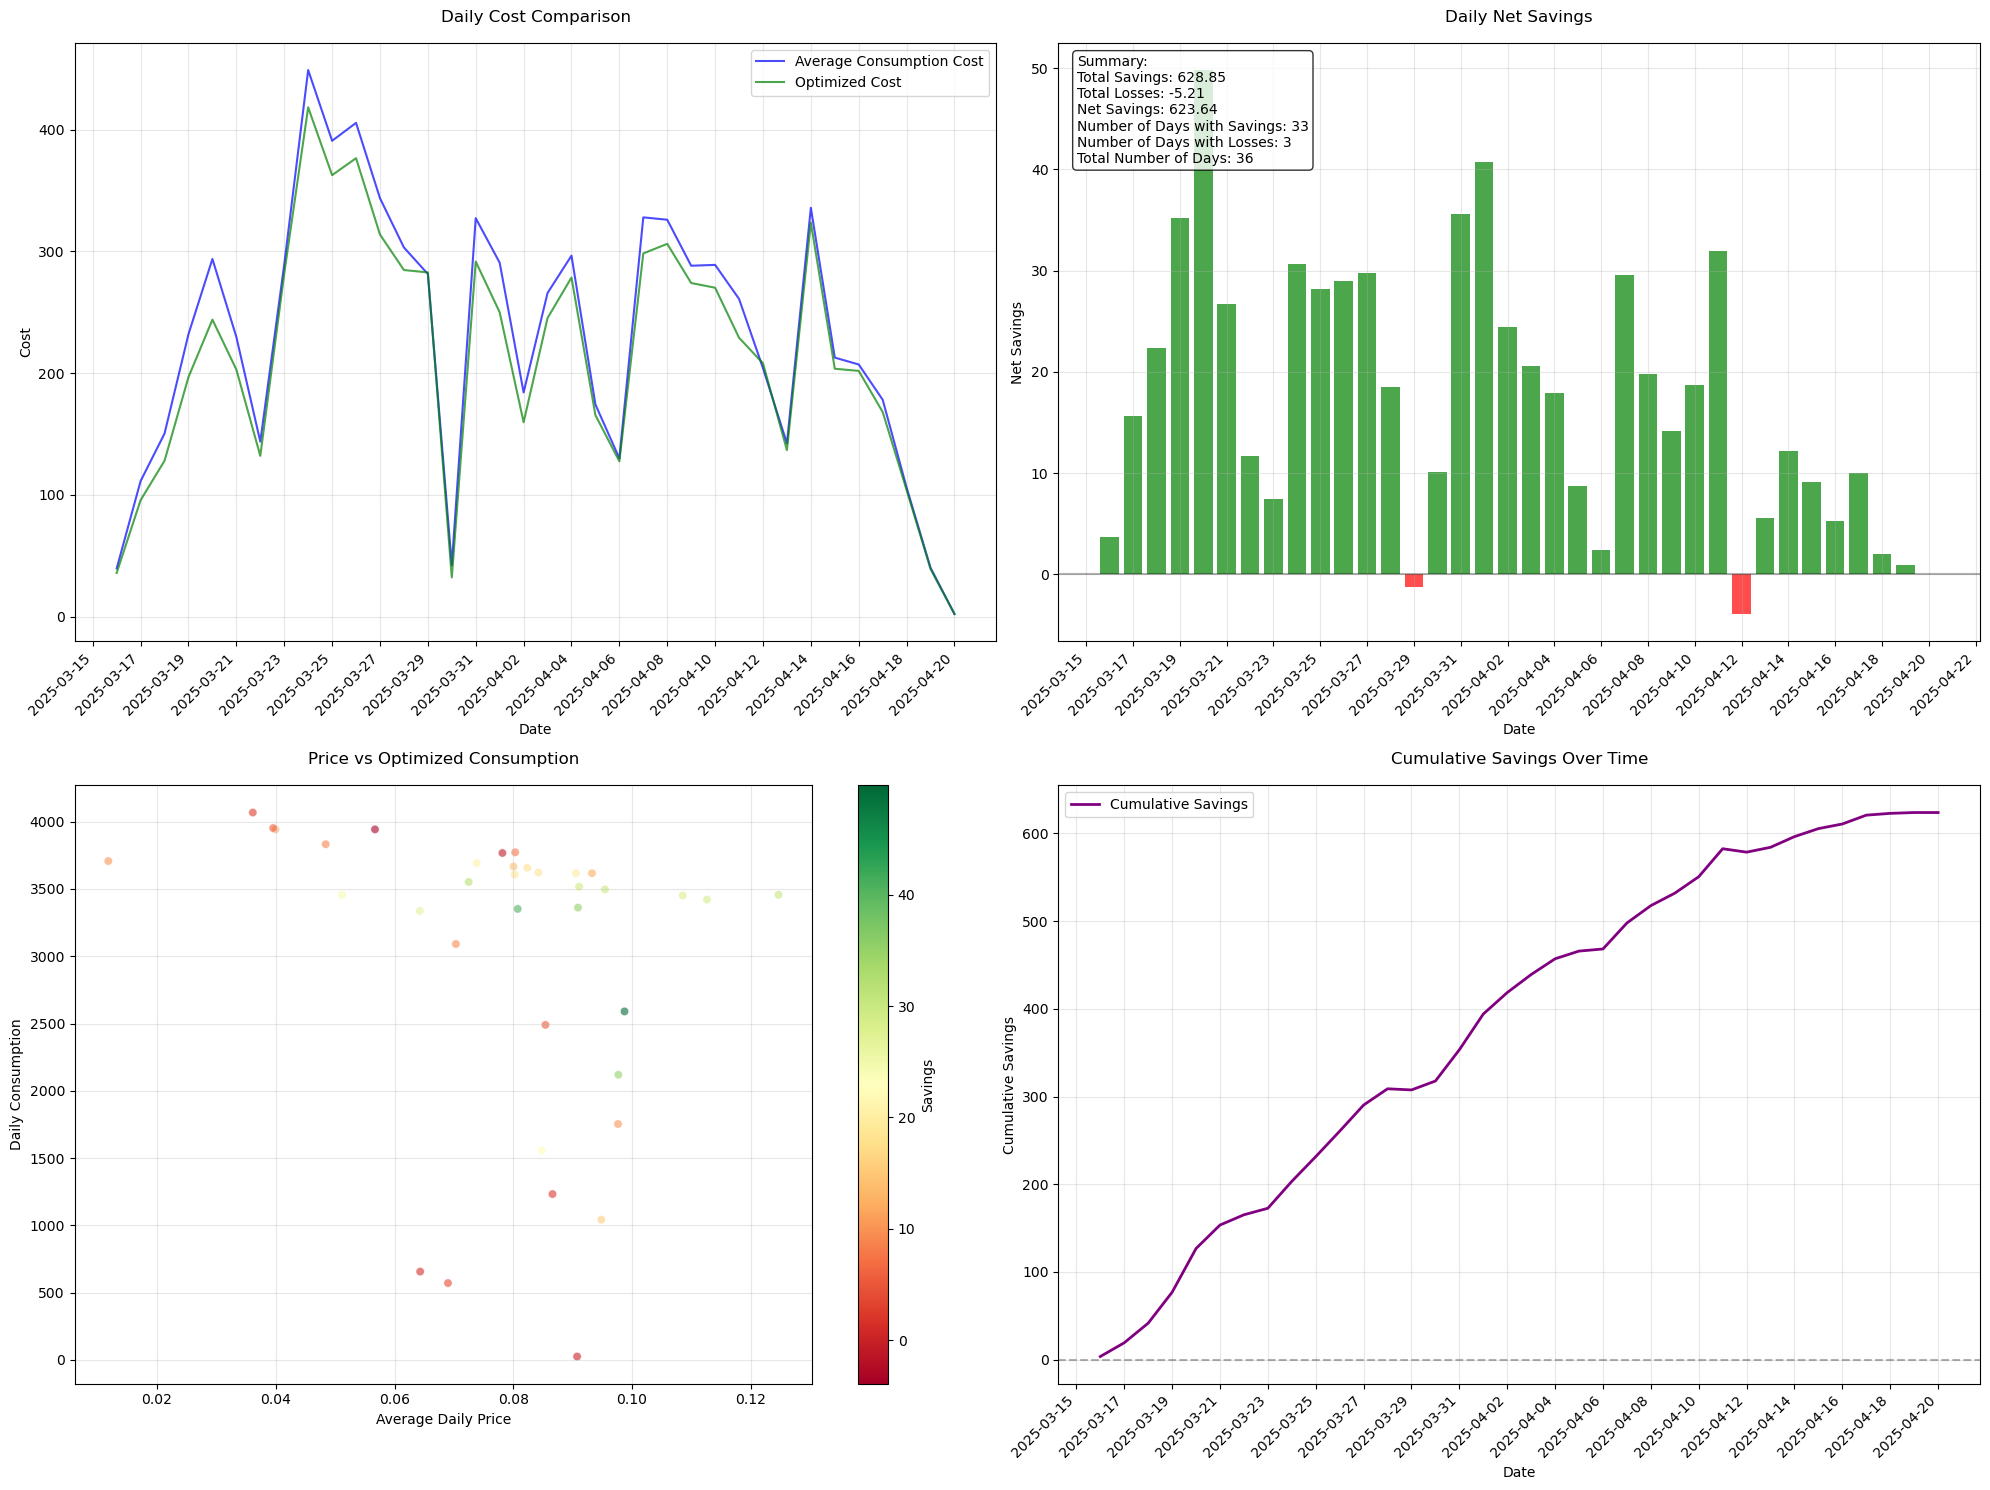

In [21]:
# Plot the results
analyzer.plot_savings(results)

## Additional Analysis

Let's add some additional analysis to understand the distribution of savings and consumption patterns.

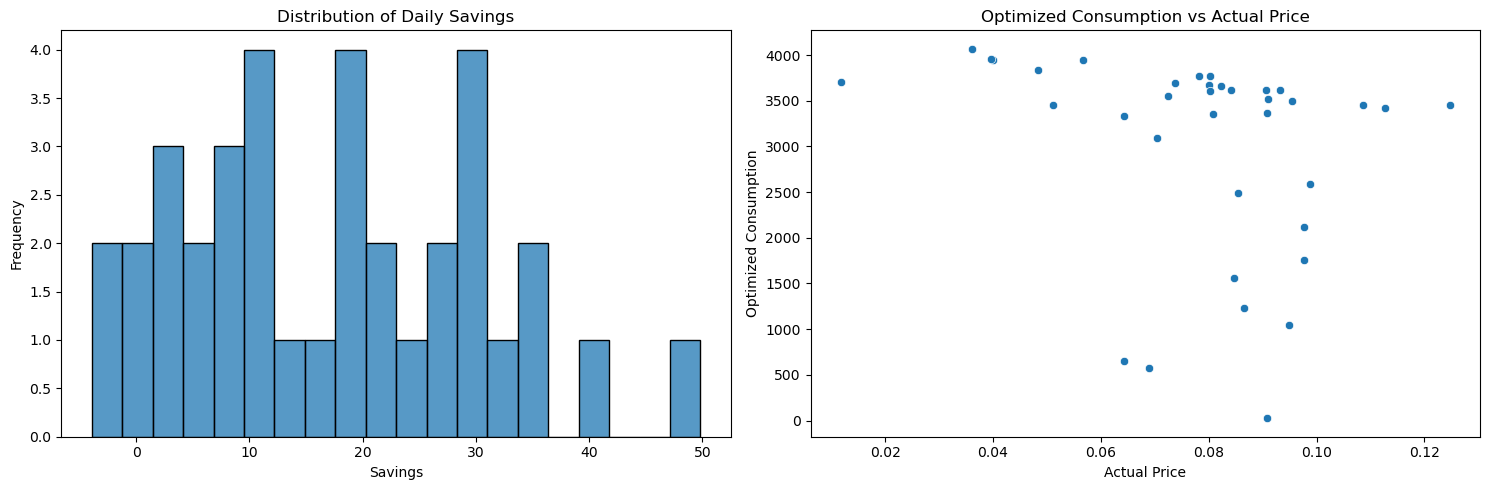

In [22]:
# Create additional visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of savings
sns.histplot(data=results, x='savings', bins=20, ax=ax1)
ax1.set_title('Distribution of Daily Savings')
ax1.set_xlabel('Savings')
ax1.set_ylabel('Frequency')

# Plot 2: Scatter plot of actual vs optimized consumption
sns.scatterplot(data=results, x='actual_price', y='optimized_consumption', ax=ax2)
ax2.set_title('Optimized Consumption vs Actual Price')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Optimized Consumption')

plt.tight_layout()
plt.show()

Analysis for Multi Model results

In [23]:
class MultiModelCostAnalyzer:
    def __init__(self, avg_daily_consumption: float = 1000.0):
        """Initialize the analyzer with average daily consumption"""
        self.avg_daily_consumption = avg_daily_consumption
        self.logger = logging.getLogger(__name__)
    
    def analyze_model_predictions(self, df: pd.DataFrame, model_name: str, 
                                actual_col: str = 'actual_price',
                                pred_col: str = 'predicted_price') -> pd.DataFrame:
        """Analyze cost savings for a specific model's predictions"""
        self.logger.info(f"Starting analysis for {model_name} model...")
        
        # Create a copy to avoid modifying the input
        results_df = df.copy()
        
        # Convert timestamp to datetime if it's not already
        results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
        
        # Create a date column for daily aggregation
        results_df['date'] = results_df['timestamp'].dt.date
        
        # Calculate costs with average consumption
        results_df['avg_consumption_cost'] = results_df[actual_col] * self.avg_daily_consumption
        
        # Optimize consumption based on predicted prices
        results_df = self.optimize_consumption(results_df, pred_col)
        
        # Calculate costs with optimized consumption
        results_df['optimized_cost'] = results_df[actual_col] * results_df['optimized_consumption']
        
        # Calculate hourly savings
        results_df['savings'] = results_df['avg_consumption_cost'] - results_df['optimized_cost']
        
        # Aggregate to daily level
        daily_results = results_df.groupby('date').agg({
            'timestamp': 'first',
            actual_col: 'mean',
            pred_col: 'mean',
            'avg_consumption_cost': 'sum',
            'optimized_cost': 'sum',
            'savings': 'sum',
            'optimized_consumption': 'sum'
        }).reset_index()
        
        # Calculate cumulative savings
        daily_results['cumulative_savings'] = daily_results['savings'].cumsum()
        
        # Add model name to the results
        daily_results['model'] = model_name
        
        return daily_results
    
    def optimize_consumption(self, df: pd.DataFrame, pred_col: str) -> pd.DataFrame:
        """Optimize consumption based on predicted prices"""
        # Create a copy of the dataframe
        df = df.copy()
        
        # Use actual prices when predicted prices are NaN
        df['price_for_optimization'] = df[pred_col].fillna(df['actual_price'])
        
        # Calculate price percentiles
        price_percentiles = df['price_for_optimization'].quantile([0.33, 0.66])
        low_price_threshold = price_percentiles[0.33]
        high_price_threshold = price_percentiles[0.66]
        
        # Initialize optimized consumption
        df['optimized_consumption'] = self.avg_daily_consumption
        
        # Count days in each price category
        low_price_days = (df['price_for_optimization'] <= low_price_threshold).sum()
        high_price_days = (df['price_for_optimization'] >= high_price_threshold).sum()
        medium_price_days = len(df) - low_price_days - high_price_days
        
        # Calculate consumption adjustments
        if low_price_days > 0:
            # On low price days, consume 20% more than average
            low_price_consumption = self.avg_daily_consumption * 1.2
            df.loc[df['price_for_optimization'] <= low_price_threshold, 'optimized_consumption'] = low_price_consumption
        
        if high_price_days > 0:
            # On high price days, consume 20% less than average
            high_price_consumption = self.avg_daily_consumption * 0.8
            df.loc[df['price_for_optimization'] >= high_price_threshold, 'optimized_consumption'] = high_price_consumption
        
        # Calculate total consumption
        total_consumption = df['optimized_consumption'].sum()
        target_consumption = self.avg_daily_consumption * len(df)
        
        # Adjust consumption to match target if needed
        if total_consumption != target_consumption:
            adjustment_factor = target_consumption / total_consumption
            df['optimized_consumption'] *= adjustment_factor
        
        return df
    
    def plot_model_comparison(self, results_dict: dict):
        """Plot comparison of savings across different models"""
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
        
        # Plot 1: Daily savings comparison
        for model_name, results in results_dict.items():
            ax1.plot(results['date'], results['savings'], 
                    label=f'{model_name} Savings', alpha=0.7)
        
        ax1.set_title('Daily Savings Comparison Across Models', fontsize=12, pad=15)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Savings')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Cumulative savings comparison
        for model_name, results in results_dict.items():
            ax2.plot(results['date'], results['cumulative_savings'], 
                    label=f'{model_name} Cumulative', alpha=0.7)
        
        ax2.set_title('Cumulative Savings Comparison', fontsize=12, pad=15)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Savings')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Box plot of daily savings
        savings_data = []
        labels = []
        for model_name, results in results_dict.items():
            savings_data.append(results['savings'])
            labels.extend([model_name] * len(results))
        
        ax3.boxplot(savings_data, labels=list(results_dict.keys()))
        ax3.set_title('Distribution of Daily Savings', fontsize=12, pad=15)
        ax3.set_ylabel('Savings')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Summary statistics
        summary_data = []
        for model_name, results in results_dict.items():
            total_savings = results['savings'][results['savings'] > 0].sum()
            total_losses = results['savings'][results['savings'] < 0].sum()
            net_savings = results['savings'].sum()
            days_with_savings = (results['savings'] > 0).sum()
            days_with_losses = (results['savings'] < 0).sum()
            
            summary_data.append({
                'Model': model_name,
                'Total Savings': total_savings,
                'Total Losses': total_losses,
                'Net Savings': net_savings,
                'Days with Savings': days_with_savings,
                'Days with Losses': days_with_losses
            })
        
        summary_df = pd.DataFrame(summary_data)
        ax4.axis('tight')
        ax4.axis('off')
        table = ax4.table(cellText=summary_df.values,
                         colLabels=summary_df.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        # Rotate x-axis labels for better readability
        for ax in [ax1, ax2]:
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

Analyser for Multi-Models

INFO:__main__:Starting analysis for Random Forest model...
INFO:__main__:Starting analysis for Oxygent model...
INFO:__main__:Starting analysis for Naive model...


                    run_date            target_datetime  predicted_Price  \
0  2025-03-15 00:00:00+00:00  2025-03-16 01:00:00+00:00         0.093036   
1  2025-03-15 00:00:00+00:00  2025-03-16 02:00:00+00:00         0.091816   
2  2025-03-15 00:00:00+00:00  2025-03-16 03:00:00+00:00         0.092445   
3  2025-03-15 00:00:00+00:00  2025-03-16 04:00:00+00:00         0.093663   
4  2025-03-15 00:00:00+00:00  2025-03-16 05:00:00+00:00         0.093793   

   actual_Price  oxygent_price  naive_price  
0       0.08579          0.083      0.08680  
1       0.07962          0.079      0.08570  
2       0.07818          0.074      0.09586  
3       0.07860          0.073      0.09772  
4       0.08051          0.076      0.09985  
Data Summary:
Number of rows: 4320
Date range: 2025-03-16 01:00:00+00:00 to 2025-04-20 00:00:00+00:00

Columns available:
['run_date', 'timestamp', 'predicted_price', 'actual_price', 'oxygent_price', 'naive_price']


/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_8617/2269086970.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(savings_data, labels=list(results_dict.keys()))


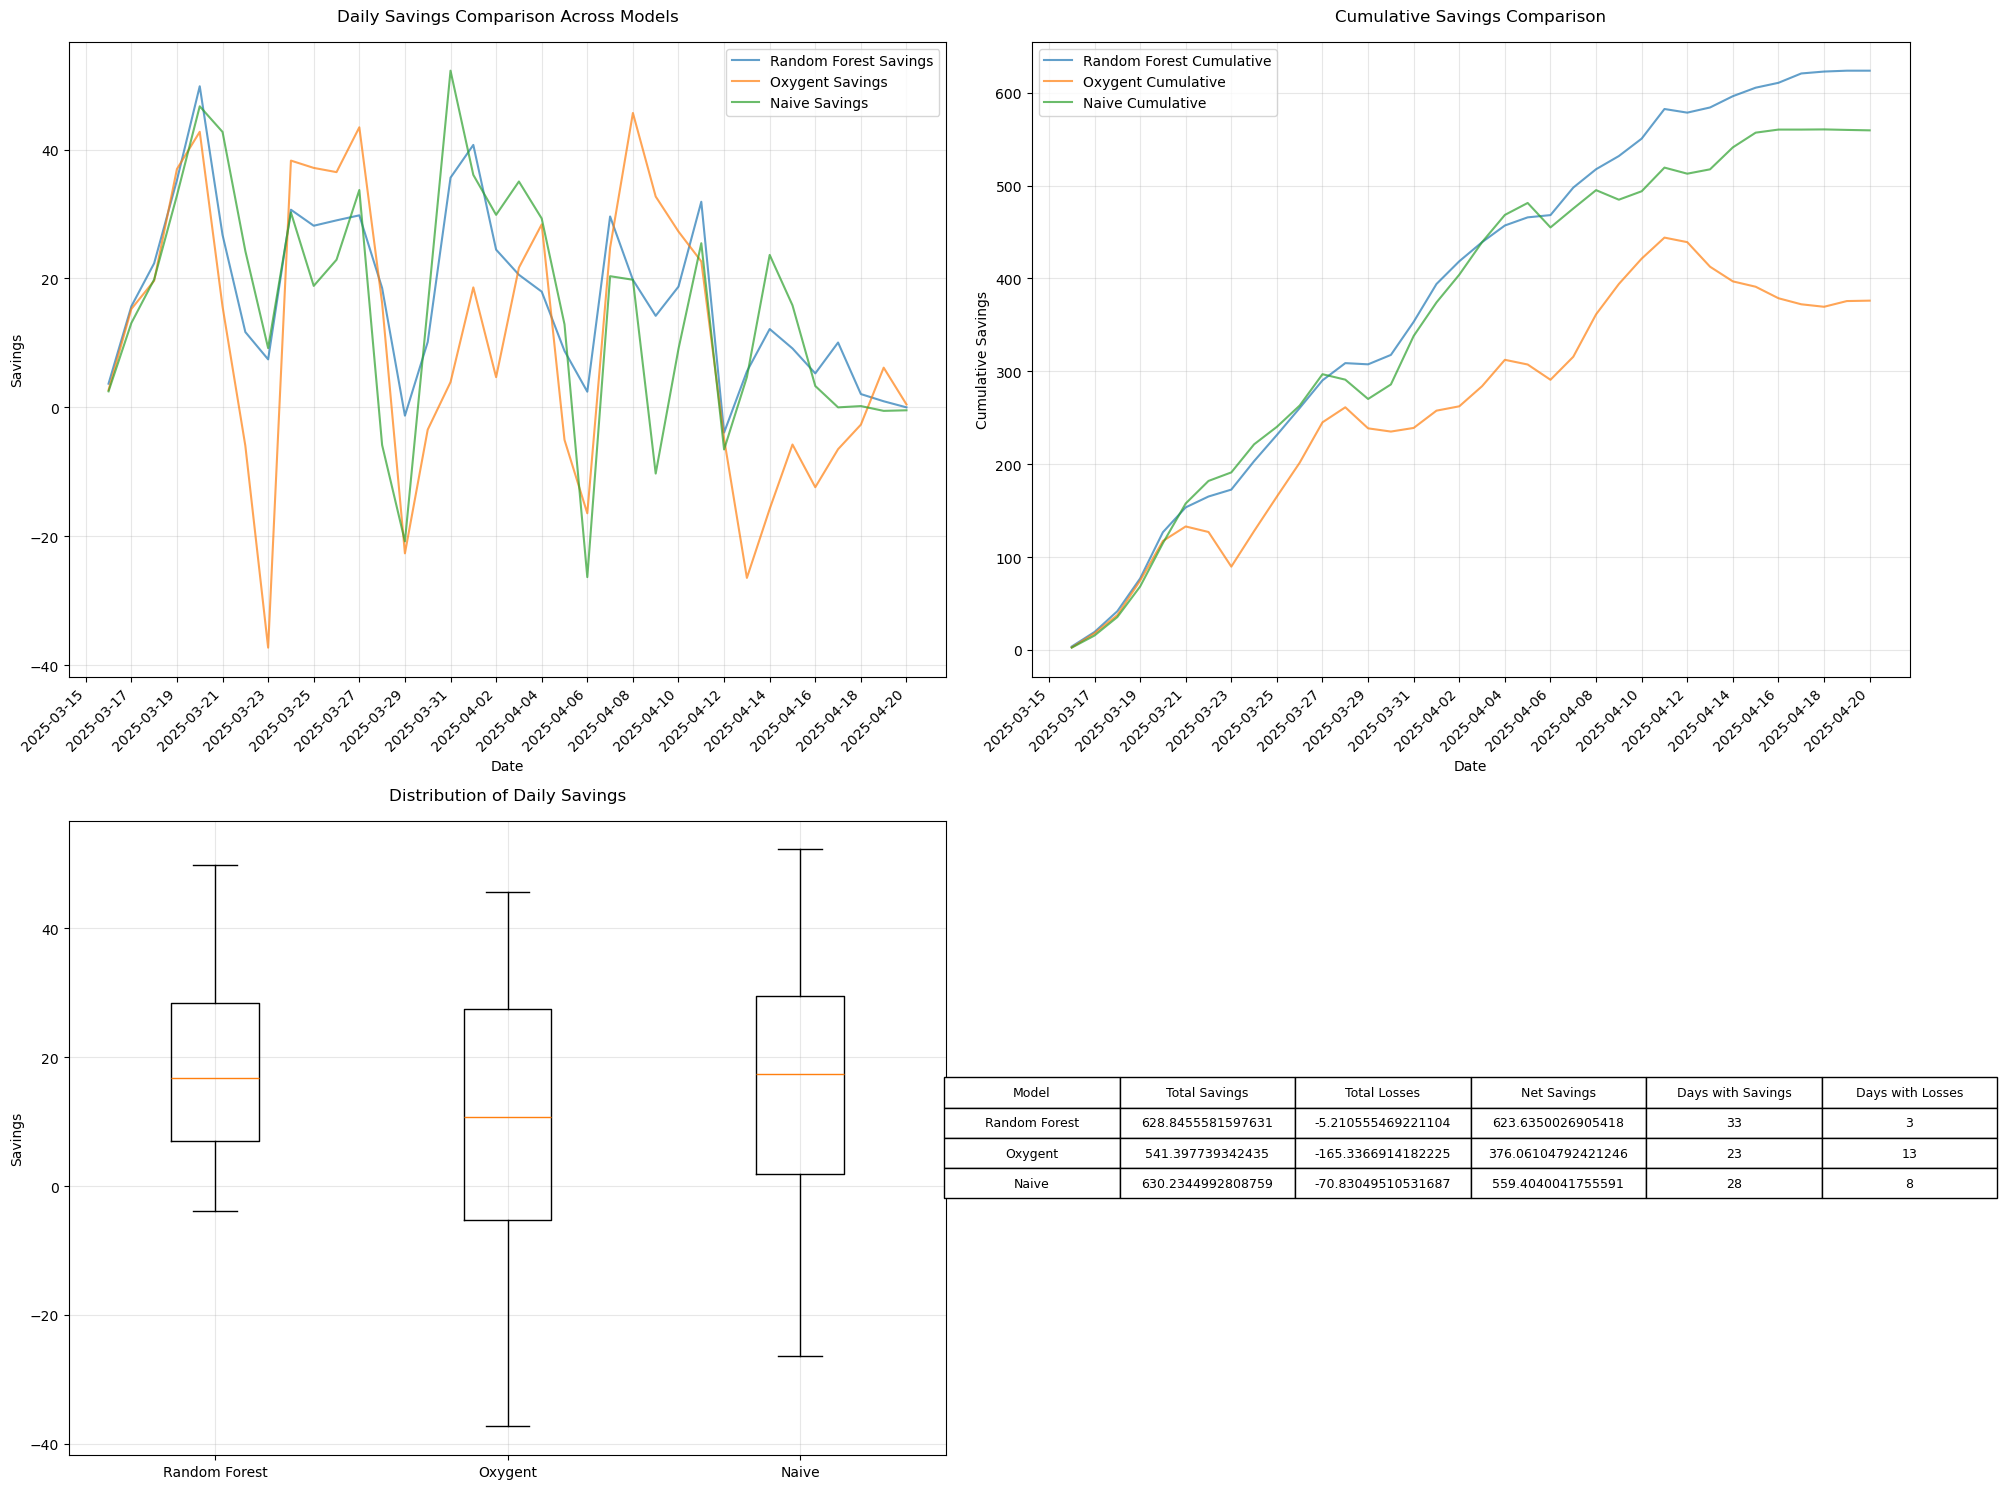

In [24]:
# First, load the data
def load_data():
    """Load and prepare the data from CSV file"""
    # Read the CSV file
    file_path = '../../sharell/random_forest_predictions_with_actuals.csv'
    df = pd.read_csv(file_path)
    print(df.head())

    df = df.rename(columns={
        'target_datetime': 'timestamp',
        'actual_Price': 'actual_price',
        'predicted_Price': 'predicted_price'
    })


    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Print data info
    print("Data Summary:")
    print(f"Number of rows: {len(df)}")
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print("\nColumns available:")
    print(df.columns.tolist())
    
    return df

# Load the data
df = load_data()

# Initialize the analyzer
analyzer = MultiModelCostAnalyzer(avg_daily_consumption=25.0)

# Analyze each model's predictions
prophet_results = analyzer.analyze_model_predictions(
    df, 
    model_name='Random Forest',
    actual_col='actual_price',
    pred_col='predicted_price'
)

oxygent_results = analyzer.analyze_model_predictions(
    df,
    model_name='Oxygent',
    actual_col='actual_price',
    pred_col='oxygent_price'
)

naive_results = analyzer.analyze_model_predictions(
    df,
    model_name='Naive',
    actual_col='actual_price',
    pred_col='naive_price'
)

# Create a dictionary of results
results_dict = {
    'Random Forest': prophet_results,
    'Oxygent': oxygent_results,
    'Naive': naive_results
}

# Plot the comparison
analyzer.plot_model_comparison(results_dict)